In [13]:
%pip install torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 34.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [69]:

from glob import glob
import pandas as pd
import requests
from PIL import Image
from io import BytesIO
from tqdm import tqdm
import os

import random
from datasets import load_dataset
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from datasets import load_from_disk
from PIL import Image

import json
from datasets import Dataset

In [71]:



def load_image(example):
  image = Image.open(example['image_path']).convert("RGB")
  example["image"] = image
  return example

image_transforms = Compose([
    Resize((512, 512)),  # Resize to model input resolution
    ToTensor(),          # Convert image to tensor and normalize to [0, 1]
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

def preprocess_image(example):
  image = example["image"]
  return example


def match_files(dir1, dir2):
    """
    Matches files from two directories by their filenames.
    Args:
        dir1: Path to the first directory.
        dir2: Path to the second directory.
    Returns:
        A list of tuples where each tuple contains matched filenames from dir1 and dir2.
    """
    # Get list of filenames in each directory
    files_dir1 = list(set(os.listdir(dir1)))
    files_dir2 = list(set(os.listdir(dir2)))
    random.shuffle(files_dir1)
    random.shuffle(files_dir2)

    dataset = []
    for file_name in files_dir1:
        file_name_prefix = file_name.split('.')[0]
        if file_name_prefix == '':
            continue
        for file_name_2 in files_dir2:
            file_name_prefix_2 = file_name_2.split('.')[0]
            if (file_name_prefix == file_name_prefix_2):
                with open(os.path.join(dir2, file_name_2), "r", encoding="utf-8") as file:
                  description = file.read()
                  dataset.append({ "name": file_name_prefix,
                                "pool-data-full-path": os.path.join(dir1, file_name),
                                "pool-data": file_name,
                                "description": description,
                                "pool-meta-full-path": os.path.join(dir2, file_name_2),
                                "pool-meta": file_name_2 })

    return dataset


def load_lora_list(dir_path_prefix):
  lora_pool_path = dir_path_prefix + '/LoRA-compos-data/lora-pool'
  lora_pool_meta_path = dir_path_prefix + '/LoRA-compos-data/lora-pool-meta'
  lora_dataset = match_files(lora_pool_path, lora_pool_meta_path)
  return lora_dataset

def load_lora_model_path(dataset, model_storage_dir):
  for lora_data in dataset:
    saving_dir = model_storage_dir + lora_data['name'];
    if os.path.exists(saving_dir):
      lora_data['model_path'] = saving_dir
  return dataset

def load_dataset(dataset_name, split="train"):
    filtered_dataset = load_from_disk("/content/drive/MyDrive/Graduate School/Stable Diffusion Finetuning/filtered_data")
    processed_dataset = filtered_dataset.map(load_image)
    lora_dataset = load_lora_list('/content/drive/MyDrive/Graduate School/Stable Diffusion Finetuning')
    lora_dataset = load_lora_model_path(lora_dataset, '/content/drive/MyDrive/Graduate School/Stable Diffusion Finetuning/stable-diffusion-1.5-with-lora/stable-diffusion-1.5-fused-with')
    dataset = load_dataset("laion/laion2B-en-aesthetic", split="train[:1%]", keep_in_memory=True)
    return dataset

def get_corresponding_prompt_prefix(lora_name, category = None):
    # Anime
    # 01:Arknights
    # 04: Nezuko
    # 06: Garreg
    # 07: Auroral
    # 08: Bamboolight
    # 10: Zero
    # 11: Handdrawn/line art
    # 14: MoXin
    # 17: Burger
    # 18: Goku
    # 22: Toast
    anime_lora_mapping = {
        "01": "Arknights",
        "04": "Nezuko",
        "06": "Garreg",
        "07": "Auroral",
        "08": "Bamboolight",
        "10": "Zero",
        "11": "Handdrawn", # line art
        "14": "MoXin",
        "17": "Burger",
        "18": "Goku",
        "22": "Toast",
    }
    reverse_anime_lora_mapping = {v: k for k, v in anime_lora_mapping.items()}

    # Reality
    # 02: JFC
    # 03: IU
    # 05: Bright
    # 09: Library
    # 12: Scarlett
    # 13: Umbrella
    # 15: Rock
    # 16: Forest (buggy prompt)
    # 19: Univ-Uniform (mahalai, Thai)
    # 20: School-Dress
    # 21: Gum
    reality_lora_mapping = {
        "02": "JFC",
        "03": "IU",
        "05": "Bright",
        "09": "Library",
        "12": "Scarlett",
        "13": "Umbrella",
        "15": "Rock",
        "16": "Forest", # (buggy prompt)
        "19": "Univ-Uniform", # (mahalai, Thai)
        "20": "School-Dress",
        "21": "Gum",
    }
    reverse_reality_lora_mapping = {v: k for k, v in reality_lora_mapping.items()}
    prefix = lora_name.split('.')[0].strip()
    matching_part = prefix.split('_')[1].strip()
    if matching_part in reverse_anime_lora_mapping and (category == "anime" or category is None):
        return reverse_anime_lora_mapping[matching_part]
    elif matching_part in reverse_reality_lora_mapping and (category == "reality" or category is None):
        return reverse_reality_lora_mapping[matching_part]
    else:
        raise ValueError(f"LoRA name {lora_name} not found in anime or reality mappings")
    
def get_corresponding_lora_name(prompt_prefix, category = None):
    anime_lora_mapping = {
        "01": "Arknights",
        "04": "Nezuko",
        "06": "Garreg",
        "07": "Auroral",
        "08": "Bamboolight",
        "10": "Zero",
        "11": "Handdrawn", # line art
        "14": "MoXin",
        "17": "Burger",
        "18": "Goku",
        "22": "Toast",
    }

    reality_lora_mapping = {
        "02": "JFC",
        "03": "IU",
        "05": "Bright",
        "09": "Library",
        "12": "Scarlett",
        "13": "Umbrella",
        "15": "Rock",
        "16": "Forest", # (buggy prompt)
        "19": "Univ-Uniform", # (mahalai, Thai)
        "20": "School-Dress",
        "21": "Gum",
    }
    if prompt_prefix in anime_lora_mapping and (category == "anime" or category is None):
        return anime_lora_mapping[prompt_prefix]
    elif prompt_prefix in reality_lora_mapping and (category == "reality" or category is None):
        return reality_lora_mapping[prompt_prefix]
    else:
        raise ValueError(f"LoRA name {lora_name} not found in anime or reality mappings")
    

if __name__ == "__main__":
    import argparse
    parser = argparse.ArgumentParser(
        description="Train the fusion of LoRAs."
    )

    parser.add_argument('--lora_path', default='models/lora/reality',
                        help='Path to the directory containing LoRA files', type=str)
    parser.add_argument('--prompt_path', default='models/prompts/reality',
                        help='Path to the directory containing prompt files', type=str)
    parser.add_argument('--height', default=1024,
                        help='Height of the generated images', type=int)
    parser.add_argument('--width', default=768,
                        help='Width of the generated images', type=int)
    parser.add_argument('--denoise_steps', default=50,
                        help='Number of denoising steps', type=int)
    parser.add_argument('--cfg_scale', default=7,
                        help='Scale for classifier-free guidance', type=float)
    parser.add_argument('--seed', default=11,
                        help='Seed for generating images', type=int)

    args = parser.parse_args()
    main(**vars(args))

"python train_fusion_of_loras.py --prompt_path '/projects/bdpp/hyi1/stable-diffusion/Heterogenous-Multi-LoRA/Multi-LoRA-Composition/gen_prompts_compose' --lora_path '/projects/bdpp/hyi1/stable-diffusion/LoRA-compos-data/lora-pool/compose'"

usage: ipykernel_launcher.py [-h] [--lora_path LORA_PATH]
                             [--prompt_path PROMPT_PATH] [--height HEIGHT]
                             [--width WIDTH] [--denoise_steps DENOISE_STEPS]
                             [--cfg_scale CFG_SCALE] [--seed SEED]
ipykernel_launcher.py: error: unrecognized arguments: --f=/Users/henryyi/Library/Jupyter/runtime/kernel-v38db5d99b70ebc3c0a6877b746eadbdcc4d4cde45.json


SystemExit: 2

/Users/henryyi/opt/anaconda3/envs/ML-Algorithm-LowerVersion/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [66]:
import torch
import torch.nn as nn
from transformers import T5Tokenizer, T5Model

class EncoderDecoderForClassification(nn.Module):
    def __init__(self, model_name, lora_set):
        super().__init__()
        self.lora_set = lora_set
        self.encoder_decoder = T5Model.from_pretrained(model_name)
        self.classifier = nn.Sequential(
            nn.Linear(self.encoder_decoder.config.d_model, 2 * self.encoder_decoder.config.d_model), 
            nn.GELU(),
            nn.Linear(2 * self.encoder_decoder.config.d_model, 1),
            )  # Classification head
        self.softmax = nn.Softmax(dim=-1)  # Convert logits to probabilities

    def forward(self, decoder_input_ids, decoder_attention_mask, class_token_indexes):
        # Get encoder and decoder outputs
        outputs = self.encoder_decoder(
            input_ids=self.lora_set.input_ids,
            attention_mask=self.lora_set.attention_mask,
            decoder_input_ids=decoder_input_ids,
            decoder_attention_mask=decoder_attention_mask,
        )

        # Use the last hidden state of the decoder (first token representation)
        decoder_hidden_state = outputs.last_hidden_state  # Shape: (batch_size, sequence_length, hidden_size)
        # class_token_hidden_state = decoder_hidden_state[:, class_token_indexes, :]

        # Gather class token hidden states using torch.gather
        index_expanded = class_token_indexes.unsqueeze(-1).expand(-1, -1, decoder_hidden_state.shape[-1])  # Shape: (batch_size, num_classes, hidden_size)
        class_token_hidden_state = torch.gather(decoder_hidden_state, dim=1, index=index_expanded)  # Shape: (batch_size, num_classes, hidden_size)

        # Pass through classification head
        logits = self.classifier(class_token_hidden_state).squeeze(-1)  # Shape: (batch_size, num_classes)
        probabilities = self.softmax(logits)

        return logits, probabilities  # Logits for training, probabilities for inference
    
from transformers import Trainer
import torch
import torch.nn as nn
from typing import Any, Dict, Union

class CustomTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        """
        A custom Trainer for fine-tuning the EncoderDecoderForClassification model.
        """
        super().__init__(*args, **kwargs)

    def compute_loss(self, model, inputs, return_outputs=False):
        """
        Custom loss computation to handle EncoderDecoderForClassification.
        """
        # Extract inputs
        labels = inputs["labels"]  # Shape: (batch_size)
        # Forward pass
        outputs = model(decoder_input_ids=inputs['decoder_input_ids'], decoder_attention_mask=inputs['decoder_attention_mask'], class_token_indexes=inputs['class_token_index_group'])
        logits = outputs[0]  # First output is the logits

        # Compute cross-entropy loss
        loss_fn = nn.CrossEntropyLoss()
        loss = loss_fn(logits, labels)

        return (loss, outputs) if return_outputs else loss
    
    def prediction_step(self, model, inputs, prediction_loss_only, ignore_keys=None):

        with torch.no_grad():
            loss, outputs = self.compute_loss(model, inputs, return_outputs=True)
        # Return loss only if required
        if prediction_loss_only:
            return loss, None, None

        # For evaluation, predictions are the rewards

        return loss, outputs, inputs['labels']


def load_dataset_from_prompts(prompts_path, loras_path, lora_metas_path):
    dataset = glob(os.path.join(prompts_path, "*.txt"))
    prompt_list = []
    lora_set = {}
    for prompt_file in dataset:
       prompt = open(prompt_file, "r", encoding="utf-8").read()
       prompt_name = prompt_file.split('/')[-1].split('.')[0].strip()
       lora_prefixes = prompt_name.split('_')[:-1]
       lora_names = [get_corresponding_lora_name(prefix) for prefix in lora_prefixes]
       lora_paths = []
       lora_meta_paths = []
       for lora_name in lora_names:
          temp_lora_meta_paths = glob(os.path.join(lora_metas_path, f'*{lora_name}.txt'))
          lora_meta_path = temp_lora_meta_paths[0] if len(temp_lora_meta_paths) > 0 else None
          lora_meta_paths.append(lora_meta_path)

          temp_lora_paths = glob(os.path.join(loras_path, f'*{lora_name}.safetensors'))
          lora_path = temp_lora_paths[0] if len(temp_lora_paths) > 0 else None
          lora_paths.append(lora_path)
          
          if lora_name not in lora_set:
            lora_meta = open(lora_meta_path, "r", encoding="utf-8").read() if lora_meta_path is not None else None
            lora_set[lora_name] = { "lora_meta": lora_meta, "lora_path": lora_path, "lora_meta_path": lora_meta_path }

       prompt_list.append({ "prompt": prompt.strip('"'), "lora_name": lora_names, "lora_path": lora_paths, "lora_meta_path": lora_meta_paths })
    return prompt_list, len(lora_set.keys()), lora_set

def build_labels(prompt_instance, lora_index, temperature = 0.2):
    labels = [ 0 ] * len(lora_index)
    for temp_lora_name in prompt_instance['lora_name']:
        labels[lora_index[temp_lora_name]] = 1
    # print('labels: ', labels)
    loss_fn = torch.nn.Softmax(dim=0)
    return { **prompt_instance, "labels": labels, "normalized_labels": loss_fn(torch.tensor(labels) / temperature).tolist() }

def main(lora_path, prompt_path, *args, **kwargs):
    prompt_list, num_loras, lora_set = load_dataset(prompt_path, lora_path)
    list_lora_set = list(lora_set)
    lora_index = { list_lora_set[i]: i for i in range(len(list_lora_set)) }

    # model_name = "t5-small"
    # num_classes = num_loras  # Replace with the actual number of classes
    # model = EncoderDecoderForClassification(model_name, num_classes)
    processed_prompt_list = [build_labels(prompt_instance, lora_index, temperature=0.1) for prompt_instance in prompt_list]
    dataset = Dataset.from_list(processed_prompt_list)
    output = { "prompt_list": processed_prompt_list, "num_loras": num_loras, "lora_set": list_lora_set }
    with open("prompt_list.json", "w") as f:
      json.dump(output, f)
    print(dataset[2])

    tokenizer = T5Tokenizer.from_pretrained("t5-small")
    tokenized_dataset = dataset.map(lambda x: tokenize_function(x, tokenizer), batched=True)
    train_model(tokenized_dataset, tokenizer)

In [9]:
import torch
from transformers import T5Tokenizer, T5Model, T5TokenizerFast
tokenizer = T5TokenizerFast.from_pretrained("t5-small");

In [72]:
prompt_path = '/Users/henryyi/Documents/University/Systems for Gen AI/Final Project/Heterogenous-Multi-LoRA/Multi-LoRA-Composition/gen_prompts_compose'
lora_path = '/Users/henryyi/Documents/University/Systems for Gen AI/Final Project/Heterogenous-Multi-LoRA/LoRA-compos-data/lora-pool/compose'
lora_meta_path = '/Users/henryyi/Documents/University/Systems for Gen AI/Final Project/Heterogenous-Multi-LoRA/LoRA-compos-data/lora-pool-meta'
prompt_list, num_loras, lora_set = load_dataset_from_prompts(prompt_path, lora_path, lora_meta_path)
list_lora_set = list(lora_set.keys())
lora_index = { list_lora_set[i]: i for i in range(len(list_lora_set)) }

In [118]:
lora_index

{'Rock': 0, 'Gum': 1, 'Library': 2, 'JFC': 3, 'Scarlett': 4}

In [117]:
processed_prompt_list = [build_labels(prompt_instance, lora_index, temperature=0.1) for prompt_instance in prompt_list]
dataset = Dataset.from_list(processed_prompt_list)
output = { "prompt_list": processed_prompt_list, "num_loras": num_loras, "lora_set": list_lora_set }
with open("prompt_list.json", "w") as f:
    json.dump(output, f)
print(dataset[2])

{'prompt': "Envision Dwayne 'The Rock' Johnson with an infectious grin, moments after successfully blowing the biggest, most vibrant bubble gum creation in history during a playful interaction with Bubble Gum (バブルガム / 泡泡糖 / Kaugummi) at image index 18.", 'lora_name': ['Rock', 'Gum'], 'lora_path': ['/Users/henryyi/Documents/University/Systems for Gen AI/Final Project/Heterogenous-Multi-LoRA/LoRA-compos-data/lora-pool/compose/14_Rock.safetensors', '/Users/henryyi/Documents/University/Systems for Gen AI/Final Project/Heterogenous-Multi-LoRA/LoRA-compos-data/lora-pool/compose/22_Gum.safetensors'], 'lora_meta_path': ['/Users/henryyi/Documents/University/Systems for Gen AI/Final Project/Heterogenous-Multi-LoRA/LoRA-compos-data/lora-pool-meta/15_Rock.txt', '/Users/henryyi/Documents/University/Systems for Gen AI/Final Project/Heterogenous-Multi-LoRA/LoRA-compos-data/lora-pool-meta/21_Gum.txt'], 'labels': [1, 1, 0, 0, 0], 'normalized_labels': [0.499966025352478, 0.499966025352478, 2.26984229811

In [162]:
def get_class_tokens(lora_indexes):
    num_classes = len(lora_indexes)
    special_tokens = [f"[CLASS_{i}]" for i in range(num_classes)]
    print(special_tokens)
    return special_tokens

def add_class_tokens_to_tokenizer(tokenizer, lora_indexes):
    class_tokens = get_class_tokens(lora_indexes)
    tokenizer.add_tokens(class_tokens)
    return tokenizer, class_tokens

In [22]:
tokenizer, class_tokens = add_class_tokens_to_tokenizer(tokenizer, list_lora_set)


['[CLASS_0]', '[CLASS_1]', '[CLASS_2]', '[CLASS_3]', '[CLASS_4]']


In [165]:
def get_class_token_input_ids(class_tokens, tokenizer):
    return tokenizer.encode(''.join(class_tokens))[:len(class_tokens)]

In [38]:
class_token_input_ids = get_class_token_input_ids(class_tokens)

[32100, 32101, 32102, 32103, 32104]

In [89]:
def tokenize_function(examples, tokenizer, class_tokens, class_token_input_ids, max_length=512):
    prompts = examples['prompt']
    prompts_with_class_tokens = [prompt + ' ' + ''.join(class_tokens) for prompt in prompts]
    print(prompts_with_class_tokens)
    tokenized_prompts = tokenizer(prompts_with_class_tokens, truncation=True, padding='max_length', max_length=max_length)
    class_token_index_group = []
    for input_ids, attention_mask in zip(tokenized_prompts['input_ids'], tokenized_prompts['attention_mask']):
        class_token_indexes = []
        for token_input_id in class_token_input_ids:
            if token_input_id in input_ids:
                index = input_ids.index(token_input_id)
                class_token_indexes.append(index)
            attention_mask[index] = 0
        class_token_index_group.append(class_token_indexes)

    return {
        "input_ids": tokenized_prompts['input_ids'],
        "attention_mask": tokenized_prompts['attention_mask'],
        "class_token_index_group": class_token_index_group,
        "lables": examples['labels'],
        "normalized_labels": examples['normalized_labels']
    }
  
#   tokenized_examples = tokenizer(examples['prompt'] + , truncation=True, padding='max_length', max_length=512)
#   class_token_input_ids = tokenizer(class_tokens, truncation=True, padding='max_length', max_length=512)
#   return {**examples, **tokenized_examples}


In [90]:
class_token_input_ids = get_class_token_input_ids(class_tokens)
processed_dataset = dataset.map(lambda x: tokenize_function(x, tokenizer, class_tokens, class_token_input_ids), batched=True)

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

["Envision the unstoppable force, Dwayne 'The Rock' Johnson, in a moment of relaxation as he captivatingly blows massive, iridescent bubble gum with vivid swirls that seem to echo his legendary strength and serious demeanor. [CLASS_0][CLASS_1][CLASS_2][CLASS_3][CLASS_4]", 'Dwayne \'The Rock\' Johnson, in the spirit of th3r0ck, embodies raw power as he focuses intently with no hair glistening under the spotlight, while simultaneously showcasing a mesmerizing display of blown bubble gum artistry—the epitome of muscle-bound precision and playful charm."\n\n--- Metadata for LoRA 1 & LoRA 2 (Combined) ---\nName: Dwayne "The Rock" Johnson, Bubble Gum Mastery\n\nDescription: A cross between the iconic th3r0ck vibe of Dwayne \'The Rock\' Johnson and a whimsical scene where blowing bubble gum becomes an artistic expression. The image captures his serious demeanor juxtaposed with the light-heartedness of creating elaborate bubbles, embodying strength and childlike wonder in one frame.\n\nImage I

In [91]:
print(tokenizer.decode(torch.tensor(processed_dataset[1]['input_ids'])))


Dwayne 'The Rock' Johnson, in the spirit of th3r0ck, embodies raw power as he focuses intently with no hair glistening under the spotlight, while simultaneously showcasing a mesmerizing display of blown bubble gum artistry—the epitome of muscle-bound precision and playful charm." --- Metadata for LoRA 1 & LoRA 2 (Combined) --- Name: Dwayne "The Rock" Johnson, Bubble Gum Mastery Description: A cross between the iconic th3r0ck vibe of Dwayne 'The Rock' Johnson and a whimsical scene where blowing bubble gum becomes an artistic expression. The image captures his serious demeanor juxtaposed with the light-heartedness of creating elaborate bubbles, embodying strength and childlike wonder in one frame. Image Index: 48 [CLASS_0] [CLASS_1] [CLASS_2] [CLASS_3] [CLASS_4] </s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

In [94]:
index = 5
tokenizer.decode(torch.tensor(processed_dataset[index]['input_ids'])[processed_dataset[index]['class_token_index_group']])

'[CLASS_0] [CLASS_1] [CLASS_2] [CLASS_3] [CLASS_4]'

In [70]:
tokenizer('prompts_with_class_tokens', truncation=True, padding='max_length', max_length=512, return_tensors='pt', device='cpu')['input_ids']

Keyword arguments {'device': 'cpu'} not recognized.


tensor([[9005,    7,  834, 4065,  834, 4057,  834,  235, 2217,    7,    1,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,  

In [47]:
Envision the unstoppable force, Dwayne 'The Rock' Johnson, in a moment of relaxation as he captivatingly blows massive, iridescent bubble gum with vivid swirls that seem to echo his legendary strength and serious demeanor. [CLASS_0] [CLASS_1] [CLASS_2] [CLASS_3] [CLASS_4] </s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

SyntaxError: invalid syntax. Perhaps you forgot a comma? (2963116080.py, line 1)

In [105]:
from dataclasses import dataclass
from typing import Any, Dict, List
from transformers import DataCollatorWithPadding


@dataclass
class CustomDataCollatorWithPadding:
    tokenizer: Any

    def __call__(self, features: List[Dict[str, Any]]) -> Dict[str, Any]:
        print(features)
        processed_features = [
            {"input_ids": f["input_ids"], "attention_mask": f["attention_mask"], "labels": f["normalized_labels"]}
            for f in features
        ]
        data_collator = DataCollatorWithPadding(tokenizer=self.tokenizer)
        batch = data_collator(processed_features)
        
        return {
            "input_ids": batch["input_ids"],
            "attention_mask": batch["attention_mask"],
            "labels": batch["labels"],
            "class_token_index_group": torch.tensor(features["class_token_index_group"]),
        }
                
data_collator = CustomDataCollatorWithPadding(tokenizer=tokenizer)    

In [106]:
data_collator(processed_dataset[0:3])


{'prompt': ["Envision the unstoppable force, Dwayne 'The Rock' Johnson, in a moment of relaxation as he captivatingly blows massive, iridescent bubble gum with vivid swirls that seem to echo his legendary strength and serious demeanor.", 'Dwayne \'The Rock\' Johnson, in the spirit of th3r0ck, embodies raw power as he focuses intently with no hair glistening under the spotlight, while simultaneously showcasing a mesmerizing display of blown bubble gum artistry—the epitome of muscle-bound precision and playful charm."\n\n--- Metadata for LoRA 1 & LoRA 2 (Combined) ---\nName: Dwayne "The Rock" Johnson, Bubble Gum Mastery\n\nDescription: A cross between the iconic th3r0ck vibe of Dwayne \'The Rock\' Johnson and a whimsical scene where blowing bubble gum becomes an artistic expression. The image captures his serious demeanor juxtaposed with the light-heartedness of creating elaborate bubbles, embodying strength and childlike wonder in one frame.\n\nImage Index: 48', "Envision Dwayne 'The Ro

TypeError: string indices must be integers

In [137]:
from transformers import TrainingArguments
def train_model(tokenized_dataset, tokenizer):

  # Initialize the model
  model = EncoderDecoderForClassification("t5-small", lora_set)

  # Define training arguments
  training_args = TrainingArguments(
      output_dir="./results",
      evaluation_strategy="epoch",
      save_strategy="epoch",
      learning_rate=5e-5,
      per_device_train_batch_size=8,
      per_device_eval_batch_size=8,
      num_train_epochs=3,
      weight_decay=0.01,
      logging_dir="./logs",
      logging_steps=50,
      load_best_model_at_end=True,
      metric_for_best_model="accuracy",
  )

  # Define the Trainer
  trainer = CustomTrainer(
      model=model,
      args=training_args,
      train_dataset=tokenized_dataset,
      eval_dataset=tokenized_dataset,
      tokenizer=tokenizer,  # Needed for data formatting
      data_collator=CustomDataCollatorWithPadding(tokenizer=tokenizer)
  )

  # Train the model
  trainer.train()

torch.Size([3, 6, 4])

In [138]:
lora_set

{'Rock': {'lora_meta': 'Name: Dwayne "The Rock" Johnson\n\nDescription: th3r0ck with no hair, muscular male, serious look on his face\n\nTrigger Words: th3r0ck',
  'lora_path': '/Users/henryyi/Documents/University/Systems for Gen AI/Final Project/Heterogenous-Multi-LoRA/LoRA-compos-data/lora-pool/compose/14_Rock.safetensors',
  'lora_meta_path': '/Users/henryyi/Documents/University/Systems for Gen AI/Final Project/Heterogenous-Multi-LoRA/LoRA-compos-data/lora-pool-meta/15_Rock.txt'},
 'Gum': {'lora_meta': 'Name: Bubble Gum (バブルガム / 泡泡糖 / Kaugummi) v2.0\n\nDescription: blow bubble gum\n\nTrigger Words: blow bubble gum',
  'lora_path': '/Users/henryyi/Documents/University/Systems for Gen AI/Final Project/Heterogenous-Multi-LoRA/LoRA-compos-data/lora-pool/compose/22_Gum.safetensors',
  'lora_meta_path': '/Users/henryyi/Documents/University/Systems for Gen AI/Final Project/Heterogenous-Multi-LoRA/LoRA-compos-data/lora-pool-meta/21_Gum.txt'},
 'Library': {'lora_meta': 'Name: Library bookshe

In [158]:
def build_lora_ensemble(lora_set, tokenizer):
    # text = "The following are the descriptions of the LoRA: \n\n"
    text = ""
    descriptions = [ f"{{[CLASS_{lora_index}]: {lora_set[lora_name]['lora_meta']}}}" for lora_index, lora_name in enumerate(lora_set.keys()) ]
    text += ';\n\n'.join(descriptions)
    text += '.'
    print(text)
    tokenized_text = tokenizer(text, truncation=True, padding='max_length', max_length=512, return_tensors='pt')
    return tokenized_text


In [159]:
tokenized_text = build_lora_ensemble(lora_set, tokenizer)

{[CLASS_0]: Name: Dwayne "The Rock" Johnson

Description: th3r0ck with no hair, muscular male, serious look on his face

Trigger Words: th3r0ck};

{[CLASS_1]: Name: Bubble Gum (バブルガム / 泡泡糖 / Kaugummi) v2.0

Description: blow bubble gum

Trigger Words: blow bubble gum};

{[CLASS_2]: Name: Library bookshelf

Description: lib bg, library bookshelf

Trigger Words: lib bg};

{[CLASS_3]: Name: Japan Vibes - Film color

Description: Japan film girl - Color

Trigger Words: film overlay
film grain};

{[CLASS_4]: Name: Scarlett Johansson

Description: scarlett, short red hair, blue eyes

Trigger Words: scarlett}.


In [155]:
tokenized_text

{'input_ids': tensor([[   37,   826,    33,     8, 15293,    13,     8,  1815,  4763,    10,
             3,     2, 32100,     3,    10,  5570,    10,   309,  1343,    29,
            15,    96,   634,  3120,   121,  5891,  7726,    10,     3,   189,
           519,    52,   632,  2406,    28,   150,  1268,     6, 19671,  5069,
             6,  2261,   320,    30,   112,   522,  2702,  6938,  4467,     7,
            10,     3,   189,   519,    52,   632,  2406,     2,   117,     3,
             2, 32101,     3,    10,  5570,    10, 30153,  2846,    51,    41,
             2,     3,    87,     3,     2,     3,    87, 24253,  1744,   635,
            23,    61,     3,   208, 24273,  7726,    10,  6019, 11144, 11406,
          2702,  6938,  4467,     7,    10,  6019, 11144, 11406,     2,   117,
             3,     2, 32102,     3,    10,  5570,    10,  5355,  1335,   107,
         10386,  7726,    10,     3,  6856,     3,   115,   122,     6,  3595,
          1335,   107, 10386,  2702,  

In [157]:
tokenizer.decode(tokenized_text['input_ids'][0])

'The following are the descriptions of the LoRA: <unk> [CLASS_0] : Name: Dwayne "The Rock" Johnson Description: th3r0ck with no hair, muscular male, serious look on his face Trigger Words: th3r0ck<unk> ; <unk> [CLASS_1] : Name: Bubble Gum (<unk> / <unk> / Kaugummi) v2.0 Description: blow bubble gum Trigger Words: blow bubble gum<unk> ; <unk> [CLASS_2] : Name: Library bookshelf Description: lib bg, library bookshelf Trigger Words: lib bg<unk> ; <unk> [CLASS_3] : Name: Japan Vibes - Film color Description: Japan film girl - Color Trigger Words: film overlay film grain<unk> ; <unk> [CLASS_4] : Name: Scarlett Johansson Description: scarlett, short red hair, blue eyes Trigger Words: scarlett<unk>.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

In [160]:
tokenized_dataset

NameError: name 'tokenized_dataset' is not defined

In [166]:
prompt_list, num_loras, lora_set = load_dataset_from_prompts(prompt_path, lora_path, lora_meta_path)
list_lora_set = list(lora_set.keys())
lora_index = { list_lora_set[i]: i for i in range(len(list_lora_set)) }

# model_name = "t5-small"
# num_classes = num_loras  # Replace with the actual number of classes
# model = EncoderDecoderForClassification(model_name, num_classes)
tokenizer = T5Tokenizer.from_pretrained("t5-small");
tokenizer, class_tokens = add_class_tokens_to_tokenizer(tokenizer, list_lora_set)
processed_prompt_list = [build_labels(prompt_instance, lora_index, temperature=0.1) for prompt_instance in prompt_list]
dataset = Dataset.from_list(processed_prompt_list)
# output = { "prompt_list": processed_prompt_list, "num_loras": num_loras, "lora_set": list_lora_set }
# with open("prompt_list.json", "w") as f:
#   json.dump(output, f)
# print(dataset[2])
class_token_input_ids = get_class_token_input_ids(class_tokens, tokenizer)
tokenized_dataset = dataset.map(lambda x: tokenize_function(x, tokenizer, class_tokens, class_token_input_ids), batched=True)
tokenized_text = build_lora_ensemble(lora_set, tokenizer)
lora_set['input_ids'] = tokenized_text['input_ids']
lora_set['attention_mask'] = tokenized_text['attention_mask']
model = EncoderDecoderForClassification("t5-small", lora_set).to(device)

['[CLASS_0]', '[CLASS_1]', '[CLASS_2]', '[CLASS_3]', '[CLASS_4]']


Map:   0%|          | 0/250 [00:00<?, ? examples/s]

["Envision the unstoppable force, Dwayne 'The Rock' Johnson, in a moment of relaxation as he captivatingly blows massive, iridescent bubble gum with vivid swirls that seem to echo his legendary strength and serious demeanor. [CLASS_0][CLASS_1][CLASS_2][CLASS_3][CLASS_4]", 'Dwayne \'The Rock\' Johnson, in the spirit of th3r0ck, embodies raw power as he focuses intently with no hair glistening under the spotlight, while simultaneously showcasing a mesmerizing display of blown bubble gum artistry—the epitome of muscle-bound precision and playful charm."\n\n--- Metadata for LoRA 1 & LoRA 2 (Combined) ---\nName: Dwayne "The Rock" Johnson, Bubble Gum Mastery\n\nDescription: A cross between the iconic th3r0ck vibe of Dwayne \'The Rock\' Johnson and a whimsical scene where blowing bubble gum becomes an artistic expression. The image captures his serious demeanor juxtaposed with the light-heartedness of creating elaborate bubbles, embodying strength and childlike wonder in one frame.\n\nImage I

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

NameError: name 'device' is not defined

In [169]:
tokenized_dataset[0]['attention_mask'].index(0)

59

In [170]:
tokenized_dataset[0]

{'prompt': "Envision the unstoppable force, Dwayne 'The Rock' Johnson, in a moment of relaxation as he captivatingly blows massive, iridescent bubble gum with vivid swirls that seem to echo his legendary strength and serious demeanor.",
 'lora_name': ['Rock', 'Gum'],
 'lora_path': ['/Users/henryyi/Documents/University/Systems for Gen AI/Final Project/Heterogenous-Multi-LoRA/LoRA-compos-data/lora-pool/compose/14_Rock.safetensors',
  '/Users/henryyi/Documents/University/Systems for Gen AI/Final Project/Heterogenous-Multi-LoRA/LoRA-compos-data/lora-pool/compose/22_Gum.safetensors'],
 'lora_meta_path': ['/Users/henryyi/Documents/University/Systems for Gen AI/Final Project/Heterogenous-Multi-LoRA/LoRA-compos-data/lora-pool-meta/15_Rock.txt',
  '/Users/henryyi/Documents/University/Systems for Gen AI/Final Project/Heterogenous-Multi-LoRA/LoRA-compos-data/lora-pool-meta/21_Gum.txt'],
 'labels': [1, 1, 0, 0, 0],
 'normalized_labels': [0.499966025352478,
  0.499966025352478,
  2.269842298119329e

In [181]:
train_test_dataset = tokenized_dataset.train_test_split(test_size=0.2, seed=42)


In [190]:
train_test_dataset['test'][6]

{'prompt': 'Scarlett Johansson with striking blue eyes, surrounded by vibrant bubble gum bubbles while in the iconic style of Japan Vibes - Film color overlay for Image Index 16."\n\n"Blue-eyed Scarlett blowing playful bubble gum bubbles against a backdrop that blends her pop culture essence with the nostalgic film grain effect, captured in the rich hues of Japan Vibes - Film color style for Image Index 16.',
 'lora_name': ['Scarlett', 'Gum', 'JFC'],
 'lora_path': ['/Users/henryyi/Documents/University/Systems for Gen AI/Final Project/Heterogenous-Multi-LoRA/LoRA-compos-data/lora-pool/compose/13_Scarlett.safetensors',
  '/Users/henryyi/Documents/University/Systems for Gen AI/Final Project/Heterogenous-Multi-LoRA/LoRA-compos-data/lora-pool/compose/22_Gum.safetensors',
  '/Users/henryyi/Documents/University/Systems for Gen AI/Final Project/Heterogenous-Multi-LoRA/LoRA-compos-data/lora-pool/compose/17_JFC.safetensors'],
 'lora_meta_path': ['/Users/henryyi/Documents/University/Systems for G

In [193]:
dataset.filter(lambda x: 'Create an illustration of Dwayne' in x['prompt'])[0]

Filter:   0%|          | 0/250 [00:00<?, ? examples/s]

{'prompt': 'Create an illustration of Dwayne \'The Rock\' Johnson in a post-apocalyptic Japan setting, where film grain texture represents the faded echoes of culture, overlaid with images from classic Japanese films that symbolize resilience amidst th3r0ck."\n\n--- Metadata for LoRA 1 + LoRA 2 ---\n"Envision Dwayne \'The Rock\' Johnson exploring a library bookshelf filled with ancient texts and vintage film reels, all set in Japan Vibes-style color palette, conveying the fusion of strength and knowledge."\n Written Prompt: "Depict an epic scene where Dwayne \'The Rock\' Johnson stands confidently amidst a meticulously detailed library bookshelf brimming with aged leather-bound books. The background is painted in Japan Vibes color scheme, enhancing the atmosphere of wisdom and endurance."\n\n--- Metadata for LoRA 1 + LoRA 3 ---\n"Illustrate Dwayne \'The Rock\' Johnson as an imposing figure who has become a legendary librarian in a world where knowledge reigns supreme. The image feature

In [195]:
print('Create an illustration of Dwayne \'The Rock\' Johnson in a post-apocalyptic Japan setting, where film grain texture represents the faded echoes of culture, overlaid with images from classic Japanese films that symbolize resilience amidst th3r0ck."\n\n--- Metadata for LoRA 1 + LoRA 2 ---\n"Envision Dwayne \'The Rock\' Johnson exploring a library bookshelf filled with ancient texts and vintage film reels, all set in Japan Vibes-style color palette, conveying the fusion of strength and knowledge."\n Written Prompt: "Depict an epic scene where Dwayne \'The Rock\' Johnson stands confidently amidst a meticulously detailed library bookshelf brimming with aged leather-bound books. The background is painted in Japan Vibes color scheme, enhancing the atmosphere of wisdom and endurance."\n\n--- Metadata for LoRA 1 + LoRA 3 ---\n"Illustrate Dwayne \'The Rock\' Johnson as an imposing figure who has become a legendary librarian in a world where knowledge reigns supreme. The image features him surrounded by towering library bookshelves, showcasing his dedication to the preservation of wisdom." Prompt: "Visualize Dwayne \'The Rock\' Johnson redefined as the titanic guardian of humanity’s collective intellect, portrayed in a grandiose setting with expansive library shelves towering around him, symbolizing his monumental role in safeguarding knowledge."\n\n--- Metadata for LoRA 2 + LoRA 3 ---\n"Craft an image where the timeless charm of Japanese cinema meets the enduring allure of literature within a modern-day library. The Japan Vibes color scheme and detailed bookshelves create a harmonious blend that honors both film and books." Prompt: "Compose a captivating scene in which the essence of classic Japanese films merges with the sanctuary of libraries, presented through an artistic fusion of vibrant Japan Vibes colors and meticulously rendered bookshelves filled with literary treasures."\n\n--- Metadata for LoRA 1 + LoRA 2 + LoRA 3 ---\n"Depict Dwayne \'The Rock\' Johnson as a cultural icon who embodies the spirit of enduring Japanese film narratives, standing tall within an elegant library setting. The image captures his stature against richly colored shelves that echo stories and sagas." Prompt: "Visualize Dwayne \'The Rock\' Johnson in a majestic tableau where he stands as a living legend, resonating with the timeless tales of Japanese cinema amidst an ornate library adorned with Japan Vibes-inspired bookshelves laden with classic films.')

Create an illustration of Dwayne 'The Rock' Johnson in a post-apocalyptic Japan setting, where film grain texture represents the faded echoes of culture, overlaid with images from classic Japanese films that symbolize resilience amidst th3r0ck."

--- Metadata for LoRA 1 + LoRA 2 ---
"Envision Dwayne 'The Rock' Johnson exploring a library bookshelf filled with ancient texts and vintage film reels, all set in Japan Vibes-style color palette, conveying the fusion of strength and knowledge."
 Written Prompt: "Depict an epic scene where Dwayne 'The Rock' Johnson stands confidently amidst a meticulously detailed library bookshelf brimming with aged leather-bound books. The background is painted in Japan Vibes color scheme, enhancing the atmosphere of wisdom and endurance."

--- Metadata for LoRA 1 + LoRA 3 ---
"Illustrate Dwayne 'The Rock' Johnson as an imposing figure who has become a legendary librarian in a world where knowledge reigns supreme. The image features him surrounded by towerin

In [197]:
tokenizer.decode([32100, 32101, 32102, 32103, 32104, 14586, 1655, 17, 2194, 2618, 7, 739, 6, 28, 710, 1131, 1268, 8072, 51, 53, 160, 1692, 2053, 6, 19, 577, 5195, 6019, 53, 8328, 11144, 11406, 41, 7793, 7310, 2846, 51, 61, 16, 8, 869, 13, 3411, 1813, 346, 7, 3, 18, 3417, 945, 6, 2651, 3, 9, 9240, 814, 8273, 1504, 38, 894, 16, 6298, 11507, 489, 535, 96, 1570, 46, 7235, 9135, 30, 1435, 4318, 10276, 6, 62, 217, 14586, 1655, 17, 2194, 2618, 7, 739, 28, 160, 5483, 710, 1131, 1268, 11, 1692, 2053, 9534, 581, 3, 9, 2461, 63, 16894, 3, 24514, 13, 3411, 1813, 346, 7, 3, 18, 3417, 945, 5, 451, 31, 7, 5908, 16, 8, 2431, 7352, 3922, 13, 6019, 53, 11144, 11406, 41, 7793, 7310, 2846, 51, 201, 298, 46, 25980, 13, 814, 8273, 769, 17, 120, 3391, 7, 160, 1023, 6, 38, 3, 99, 45, 6298, 11507, 489, 535, 96, 188, 28672, 3112, 213, 14586, 1655, 17, 2194, 2618, 7, 739, 6, 28, 710, 1131, 1268, 11, 3, 8343, 75, 53, 1692, 2053, 6, 12902, 6257, 20626, 12, 3, 9, 28362, 4318, 1898, 5, 451, 31, 7, 894, 6019, 53, 11144, 11406, 41, 7793, 7310, 2846, 51, 61, 3, 9, 12342, 8, 29682, 7111, 13, 3411, 1813, 346, 7, 3, 18, 3417, 945, 6, 743, 28, 46, 1023, 5538, 489, 18, 18507, 814, 8273, 25980, 24, 617, 7, 4963, 11, 6519, 5, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

'[CLASS_0] [CLASS_1] [CLASS_2] [CLASS_3] [CLASS_4] Scarlett Johansson, with short red hair framing her blue eyes, is playfully blowing vibrant bubble gum (Bubble Gum) in the style of Japan Vibes - Film color, adding a subtle film grain effect as seen in Image Index 7." "In an artistic twist on traditional Japanese cinema, we see Scarlett Johansson with her signature short red hair and blue eyes captured against a dreamy backdrop reminiscent of Japan Vibes - Film color. She\'s engaged in the classic childhood joy of blowing bubble gum (Bubble Gum), while an overlay of film grain subtly enhances her image, as if from Image Index 7." "A captivating scene where Scarlett Johansson, with short red hair and piercing blue eyes, finds herself transported to a serene Japanese setting. She\'s seen blowing bubble gum (Bubble Gum) amidst the nostalgic charm of Japan Vibes - Film color, complete with an image index 7-inspired film grain overlay that adds depth and texture.</s><pad><pad><pad><pad><pa

In [199]:

model = EncoderDecoderForClassification("t5-small", lora_set)

In [201]:
training_dataset = train_test_dataset['train']

In [206]:
torch.tensor(training_dataset[0]['input_ids'])

tensor([  695,  6610,    46,  3865,  3595,  1335,   107, 10386,  3827,    15,
           26,    16,  1978, 21128,   659,     6,   213,   284,  8625,    19,
            3, 29532,    28,  2431,  4318,  6678,    18, 24186,  3792,    41,
         6856,     3,   115,   122,   201, 20302, 19731,    28,     8,  5917,
          814,  8273,  1504,     3, 24514,    13,     3,     9,    57, 16967,
            3,  1498,    31,     7, 20362,  7111,    41,  9988, 25980,     6,
          814,  8273,   201,  1577,    46, 25786,  3411,  1813,   346,     7,
         4643,    16,  1023,  5538,  6862,     5, 32100, 32101, 32102, 32103,
        32104,     1,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

In [214]:
from PIL import Image
from transformers import CLIPProcessor
image_path = "/Users/henryyi/Documents/University/Systems for Gen AI/Final Project/Heterogenous-Multi-LoRA/LoRA-compos-data/lora-pool-img/1_Nezuko.jpeg"
image = Image.open(image_path).convert("RGB")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

inputs = processor(images=image, return_tensors="pt")

# Encode the image
with torch.no_grad():
    image_features = clip_model.get_image_features(**inputs)

# Normalize the embedding
image_features = image_features / image_features.norm(p=2, dim=-1, keepdim=True)

In [216]:
image_features.shape

torch.Size([1, 512])

In [220]:
inputs['pixel_values'].shape

torch.Size([1, 3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7922626..2.145897].


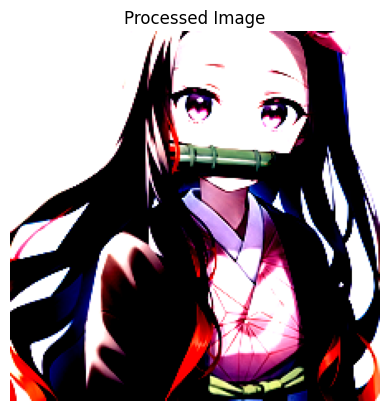

In [223]:
import matplotlib.pyplot as plt
# Display the image
plt.imshow(inputs['pixel_values'][0].permute(1, 2, 0))
plt.axis("off")
plt.title("Processed Image")
plt.show()

In [207]:
from transformers import CLIPModel
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

In [209]:
clip_model.encode_text(torch.tensor(training_dataset[0]['input_ids']))

AttributeError: 'CLIPModel' object has no attribute 'encode_text'

In [204]:
model.encoder_decoder.encoder(inputs_embeds=torch.tensor(training_dataset[0]['input_ids']))

ValueError: not enough values to unpack (expected 2, got 0)

In [5]:
test_text = '{CLASS_1: I have an apple}'

In [ ]:
tokenizer = T5Tokenizer

In [11]:
tokenized_results = tokenizer(test_text, truncation=True, padding='max_length', max_length=512, return_tensors='pt', return_offsets_mapping=True,)

In [12]:
tokenized_results

{'input_ids': tensor([[    3,     2, 31598,   834,   536,    10,    27,    43,    46,  8947,
             2,     1,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,  

In [16]:
tokenizer.decode(3)

''

In [76]:
def reverse_token_mapping(text_indexes, offset_mappings):
    matched_mapping_indexes = []
    for index, mapping in enumerate(offset_mappings):
        if mapping[0].item() <= text_indexes[0] and mapping[1].item() >= text_indexes[1]:
            matched_mapping_indexes.append(index)
    return matched_mapping_indexes


In [65]:
lora_set

NameError: name 'lora_set' is not defined

In [67]:
prompt_list, num_loras, lora_set = load_dataset_from_prompts(prompt_path, lora_path, lora_meta_path)

NameError: name 'prompt_path' is not defined

In [73]:
lora_set

{'Rock': {'lora_meta': 'Name: Dwayne "The Rock" Johnson\n\nDescription: th3r0ck with no hair, muscular male, serious look on his face\n\nTrigger Words: th3r0ck',
  'lora_path': '/Users/henryyi/Documents/University/Systems for Gen AI/Final Project/Heterogenous-Multi-LoRA/LoRA-compos-data/lora-pool/compose/14_Rock.safetensors',
  'lora_meta_path': '/Users/henryyi/Documents/University/Systems for Gen AI/Final Project/Heterogenous-Multi-LoRA/LoRA-compos-data/lora-pool-meta/15_Rock.txt'},
 'Gum': {'lora_meta': 'Name: Bubble Gum (バブルガム / 泡泡糖 / Kaugummi) v2.0\n\nDescription: blow bubble gum\n\nTrigger Words: blow bubble gum',
  'lora_path': '/Users/henryyi/Documents/University/Systems for Gen AI/Final Project/Heterogenous-Multi-LoRA/LoRA-compos-data/lora-pool/compose/22_Gum.safetensors',
  'lora_meta_path': '/Users/henryyi/Documents/University/Systems for Gen AI/Final Project/Heterogenous-Multi-LoRA/LoRA-compos-data/lora-pool-meta/21_Gum.txt'},
 'Library': {'lora_meta': 'Name: Library bookshe

In [131]:
def build_lora_ensemble(lora_set, tokenizer):
    # text = "The following are the descriptions of the LoRA: \n\n"
    text = ""
    descriptions = []
    class_delimiter_indexes = []
    for lora_index, lora_name in enumerate(lora_set.keys()):
        class_description = f"{{[CLASS_{lora_index}]: {lora_set[lora_name]['lora_meta']}.}}"
        # class_delimiter_index = class_description.rfind('}')
        class_delimiter_index = len(class_description) - 1
        class_delimiter_indexes.append(class_delimiter_index)
        descriptions.append(class_description)
    seperator = ';\n\n'
    text += seperator.join(descriptions)
    text += '.'
    for i in range(len(class_delimiter_indexes)):
        class_delimiter_indexes[i] = class_delimiter_indexes[i] + (class_delimiter_indexes[i - 1] + len(seperator) + 1 if i > 0 else 0)
    tokenized_text = tokenizer(text, truncation=True, padding='max_length', max_length=512, return_tensors='pt', return_offsets_mapping=True)
    offset_mappings = tokenized_text.offset_mapping

    class_delimiter_token_indexes = []
    for class_delimiter_index in class_delimiter_indexes:
        class_delimiter_token_indexes.append(reverse_token_mapping([class_delimiter_index, class_delimiter_index + 1], offset_mappings[0])[0])

    return tokenized_text, class_delimiter_token_indexes

In [144]:
def tensor_insert(tensor, value, index, dim):
    # Ensure value has the correct number of dimensions
    if tensor.dim() != value.dim():
        raise ValueError("Value must have the same number of dimensions as the input tensor.")

    # Split the tensor along the specified dimension
    if index > tensor.size(dim):
        raise IndexError(f"Index {index} is out of bounds for dimension {dim} with size {tensor.size(dim)}")

    # Slice and concatenate
    before = tensor.narrow(dim, 0, index)  # Select everything before the index
    after = tensor.narrow(dim, index, tensor.size(dim) - index)  # Select everything after the index
    return torch.cat([before, value, after], dim=dim)

In [137]:
text[240: 246]

'gger W'

In [138]:
model = T5Model.from_pretrained("t5-small")

In [143]:
tokenized_text['input_ids'].shape

torch.Size([1, 512])

In [149]:
input_embeddings = model.shared(tokenized_text['input_ids'])

In [132]:
tokenized_text, class_delimiter_token_indexes = build_lora_ensemble(lora_set, tokenizer)

In [150]:
input_embeddings

tensor([[[ 11.2500,   8.0625,  14.1875,  ...,   9.8125,  -7.8750,  -3.6094],
         [ -8.7500,   7.1875,  27.8750,  ..., -26.7500,   0.8555,  -1.5156],
         [-13.0000,   6.7812, -11.0000,  ...,  11.3125,   8.3125,   8.2500],
         ...,
         [ -2.0156,   0.2236,  -7.0938,  ...,  -0.3535,   2.6406,  -2.8906],
         [ -2.0156,   0.2236,  -7.0938,  ...,  -0.3535,   2.6406,  -2.8906],
         [ -2.0156,   0.2236,  -7.0938,  ...,  -0.3535,   2.6406,  -2.8906]]],
       grad_fn=<EmbeddingBackward0>)

In [151]:
input_embeddings.dim()

3

In [170]:
to_insert_embeddings = torch.tensor([[[1000], [2000]]]).expand(-1, -1, 512)
inserted_embeddings = input_embeddings.clone()
for class_delimiter_token_index in class_delimiter_token_indexes:
    print(tokenizer.decode(tokenized_text['input_ids'][0][class_delimiter_token_index]))
    inserted_embeddings = tensor_insert(inserted_embeddings, to_insert_embeddings, class_delimiter_token_index, 1)

<unk>
<unk>
<unk>
<unk>
<unk>


In [179]:
inserted_embeddings.shape
for class_delimiter_token_index in class_delimiter_token_indexes:
    print(tokenizer.decode(tokenized_text['input_ids'][0][class_delimiter_token_index]))
    print(input_embeddings[:, class_delimiter_token_index, :])
    print(inserted_embeddings[:, class_delimiter_token_index + 1, :])

<unk>
tensor([[ -8.7500,   7.1875,  27.8750,  19.3750,   1.1094, -12.9375,  -6.6562,
          -5.3125,  -7.2188, -35.7500, -24.8750,   0.4746, -15.6875,  -5.5000,
         -10.4375,  11.1250,   1.2812, -14.9375,   8.4375,   3.7969,  -5.7500,
          19.1250, -15.0625, -11.5625, -23.2500,   6.0000,  28.7500,   2.1719,
         -34.5000,  -7.9062,  29.5000,  -6.5312,   7.3125,  11.9375,   2.5312,
          -6.0312,   2.4375,  -4.2500, -20.2500, -39.2500,   6.5312, -25.7500,
         -12.5000,  -3.8906,   2.4219,   7.3125,  10.8750,  12.5000, -18.0000,
          28.7500,  12.1875, -12.7500, -25.7500,  -6.8438,  -3.2500,  14.3750,
          20.1250,   0.9258,   9.3750,  -4.0625,  -0.3320,  10.1250,   5.6562,
          30.0000,  17.1250,  -9.3125,   6.0000, -18.1250,  -8.9375,   1.3281,
         -13.9375,  11.7500, -14.0625, -37.2500,  -5.9375,  -3.9062, -16.1250,
          20.5000,  15.8750, -18.2500,  16.6250,  13.1250,  12.3750, -15.0625,
         -15.3750, -20.3750,  -5.4375,  16.375

In [136]:
for class_delimiter_token_index in class_delimiter_token_indexes:
    print(tokenizer.decode(tokenized_text['input_ids'][0][class_delimiter_token_index+1]))

;
;
;
;
.


In [ ]:
ck
gum
g
grain
t

In [81]:
text = '''{[CLASS_0]: Name: Dwayne "The Rock" Johnson

Description: th3r0ck with no hair, muscular male, serious look on his face

Trigger Words: th3r0ck};

{[CLASS_1]: Name: Bubble Gum (バブルガム / 泡泡糖 / Kaugummi) v2.0

Description: blow bubble gum

Trigger Words: blow bubble gum};

{[CLASS_2]: Name: Library bookshelf

Description: lib bg, library bookshelf

Trigger Words: lib bg};

{[CLASS_3]: Name: Japan Vibes - Film color

Description: Japan film girl - Color

Trigger Words: film overlay
film grain};

{[CLASS_4]: Name: Scarlett Johansson

Description: scarlett, short red hair, blue eyes

Trigger Words: scarlett}.'''


In [118]:
class_delimiter_indexes = [143, 267, 369, 493, 608]
for index in class_delimiter_indexes:
    print(text[index])


}
}
}
}
}


In [37]:
index = test_text.index('{CLASS_1')
reverse_token_mapping([25, 26], tokenized_results['offset_mapping'][0])

[10]

In [35]:
tokenized_results['offset_mapping'][0]

[[0, 1],
 [0, 1],
 [1, 6],
 [6, 7],
 [7, 8],
 [8, 9],
 [10, 11],
 [12, 16],
 [17, 19],
 [20, 25],
 [25, 26],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],


In [41]:
tokenizer.decode(tokenized_results['input_ids'][0][9])

'apple'

In [29]:
test_text.index('}')

25

In [58]:
def tensor_insert(tensor, value, index, dim):
    # Ensure value has the correct number of dimensions
    if tensor.dim() != value.dim():
        raise ValueError("Value must have the same number of dimensions as the input tensor.")

    # Split the tensor along the specified dimension
    if index > tensor.size(dim):
        raise IndexError(f"Index {index} is out of bounds for dimension {dim} with size {tensor.size(dim)}")

    # Slice and concatenate
    before = tensor.narrow(dim, 0, index)  # Select everything before the index
    after = tensor.narrow(dim, index, tensor.size(dim) - index)  # Select everything after the index
    return torch.cat([before, value, after], dim=dim)

In [55]:
test_tensor = tokenized_results['input_ids'].clone()

In [61]:
test_tensor.shape

torch.Size([1, 512])

In [63]:
tensor_insert(test_tensor, torch.tensor([[1000, 2000]]), 25, 1).shape

ValueError: Value must have the same number of dimensions as the input tensor.

In [54]:
test_tensor.shape

torch.Size([512])

In [21]:
for mapping_sequence in tokenized_results['offset_mapping']:
    for mapping in mapping_sequence:
        print(test_text[mapping[0]:mapping[1]])

{
{
CLASS
_
1
:
I
have
an
apple
}





















































































































































































































































































































































































































































































































